In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from grad import Value
from nn import MLP  # Or use the provided MLP implementation below

In [ ]:
df = pd.read_csv("moonDataset.csv")  # Ensure this file is in your working directory
print(df.head())


         X1        X2        X3  label
0 -0.926767 -0.111073  0.086017      0
1 -0.917583  0.706006  0.058041      0
2  0.437984  0.899093  0.072543      0
3  0.089694  0.291446  0.070444      1
4  0.110672 -0.070806 -0.090376      1


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Check basic info about the dataset
print(f"Dataset shape: {df.shape}")
print("\nClass distribution:")
print(df['label'].value_counts())

# Split the data into features (X) and target (y)
X = df[['X1', 'X2', 'X3']]
y = df['label']

# Create train and test splits (80% train, 20% test is common)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the shapes to verify
print("\nTraining set shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print("\nTest set shape:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Optional: Check class distribution in train and test sets
print("\nTraining set class distribution:")
print(y_train.value_counts())
print("\nTest set class distribution:")
print(y_test.value_counts())

Dataset shape: (200, 4)

Class distribution:
label
0    100
1    100
Name: count, dtype: int64

Training set shape:
X_train: (160, 3)
y_train: (160,)

Test set shape:
X_test: (40, 3)
y_test: (40,)

Training set class distribution:
label
0    80
1    80
Name: count, dtype: int64

Test set class distribution:
label
0    20
1    20
Name: count, dtype: int64


In [18]:
train_df = X_train.copy()
train_df['label'] = y_train

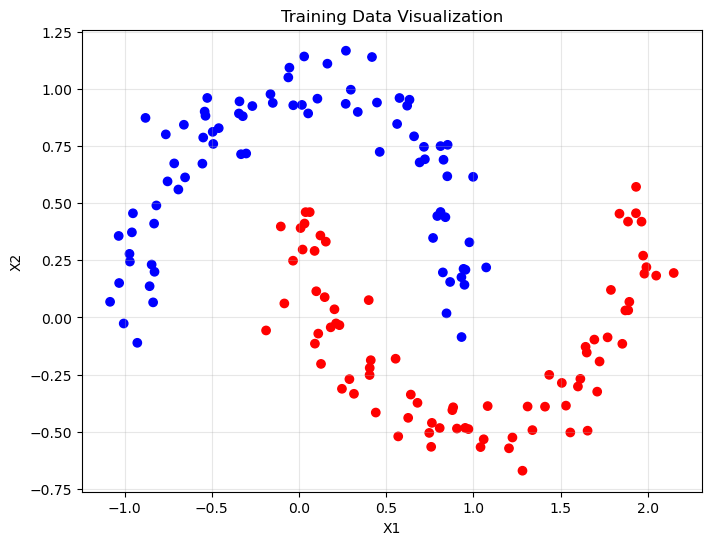

Training set size: 160 samples


In [20]:
# Visualize only the training dataset
plt.figure(figsize=(8, 6))
plt.scatter(train_df['X1'], train_df['X2'], c=train_df['label'], cmap='bwr')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Training Data Visualization')
plt.grid(alpha=0.3)
plt.show()

# Optional: Print training set size
print(f"Training set size: {len(train_df)} samples")

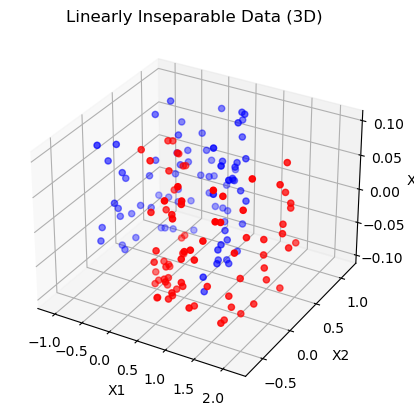

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot
ax.scatter(train_df['X1'], train_df['X2'], train_df['X3'], c=train_df['label'], cmap='bwr')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('Linearly Inseparable Data (3D)')

plt.show()


In [23]:
# Prepare data for training
X = train_df[['X1', 'X2', 'X3']].values.tolist()
y = train_df['label'].tolist()
y = [1 if label == 1 else -1 for label in train_df['label']]



# Convert labels to Value (0 or 1)
def to_value_label(y):
    return Value(y)

In [24]:
model = MLP(3, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP([
  Layer([ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)]),
  Layer([ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)]),
  Layer([LinearNeuron(16)])
])
number of parameters 353


In [26]:
import numpy as np
def loss():
    
    # inline DataLoader :)
    Xb, yb = X, y
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.0770693230611024, grad=0.0) 0.48125


In [27]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.0770693230611024, accuracy 48.125%
step 1 loss 0.9266853798223023, accuracy 77.5%
step 2 loss 1.2082569212189693, accuracy 53.75%
step 3 loss 1.1699959768977388, accuracy 80.0%
step 4 loss 0.3969815016696145, accuracy 80.0%
step 5 loss 0.3177555798406385, accuracy 84.375%
step 6 loss 0.2738373003730723, accuracy 86.875%
step 7 loss 0.2334057206777913, accuracy 91.25%
step 8 loss 0.20858294349901726, accuracy 91.25%
step 9 loss 0.189379795609435, accuracy 94.375%
step 10 loss 0.17351938289323396, accuracy 94.375%
step 11 loss 0.16125883484912926, accuracy 95.0%
step 12 loss 0.14645839880223468, accuracy 97.5%
step 13 loss 0.13353208275508222, accuracy 95.0%
step 14 loss 0.12555831833858278, accuracy 96.875%
step 15 loss 0.12271071073632103, accuracy 96.875%
step 16 loss 0.15732537859175327, accuracy 95.0%
step 17 loss 0.4081935879175391, accuracy 89.375%
step 18 loss 0.1659314204013757, accuracy 92.5%
step 19 loss 0.10211906849876902, accuracy 95.0%
step 20 loss 0.06774875

In [28]:
import numpy as np

def eval_test_accuracy():
    # Use the test data
    Xb, yb = X_test.values, y_test.values
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # Forward the model to get scores
    scores = list(map(model, inputs))
    
    # Calculate loss on test data
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # Calculate accuracy on test data
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    test_accuracy = sum(accuracy) / len(accuracy)
    
    return total_loss, test_accuracy

# Evaluate on test set
test_loss, test_acc = eval_test_accuracy()
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc:.4f} ({int(test_acc * len(X_test))}/{len(X_test)} samples)")

# Optional: Compare with training accuracy
train_loss, train_acc = loss()  # Your existing function for training data
print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: Value(data=0.512167198305492, grad=0.0)
Test Accuracy: 1.0000 (40/40 samples)

Training Accuracy: 1.0000
Test Accuracy: 1.0000
